# The Materials API

### Presented by: John Dagdelen

In this module, we will learn how to interact with the Materials Project database and go through some practical exaples of combining our own code with MP data to uncover new materials insights. We will do this through the Materials API (MAPI), which is an open API for accessing Materials Project data based on [Representational state transfer (REST)](https://en.wikipedia.org/wiki/Representational_state_transfer) principles.

In this module, we cover:

* The Materials Project API (MAPI).
* Getting your Materials Project API key.
* The `pymatgen.MPRester` built-ins.
* The `MPRester.query` method for accessing the MP database.
* The [mapidoc](https://github.com/materialsproject/mapidoc) (Materials Project documentation) repository.
* Accessing the API more directly, with plain HTTP requests, via the Python `requests` library. (Is this important for the MP Workshop?)
* Examples of API usage to get chemical system entries for generating phase diagrams and calculating reaction energies. (change this?)

## Section 0: Getting an API key

The first step to getting started with the API is to get an API key. API keys are unique identifiers that are used to track and control how the API is being used. 

To get yours, go to the dashboard page on the Materials Project website (https://materialsproject.org/dashboard). Click the 'Generate API key' button and copy the string under the button; this is your API key.

Paste your key in as the value inside the quotation marks ("") below, which will assign it the environment variable name MAPI_KEY.

In [11]:
import os
os.environ['MAPI_KEY'] = "PASTE YOUR API KEY HERE"
# os.environ['MAPI_KEY'] = "Mw5HXJN7sRfVADEl"

# # MAPI_KEY = "PASTE YOUR API KEY HERE"
# MAPI_KEY = "Mw5HXJN7sRfVADEl"

## Section 1: The MPRester

In this section we will:

* Open the pymatgen.MPRester web documentation.
* Create our first instance of an MPRester object.
* Get our feet wet with calling a few of the MPRester's "specialty" methods.
* Introduce the powerful `query` method. 



#### Background and Documentation

REST is a widely used type of standardization that allows different computer systems to work together. In RESTful systems, information is organized into resources, each of which is uniquely identified via a uniform resource identifier (URI). Since MAPI is a RESTful system, users can interact with the MP database regardless of their computer system or programming language (as long as it supports basic http requests.)

[NOTE: Should we do an example using the requests library before or after introducing the MPRester?]

To facilitate researchers in using our API, we implemented a convenient wrapper for it in the Python Materials Genomics (pymatgen) library called the `MPRester`. You can find the relevant pymatgen documentation for it [here](http://pymatgen.org/pymatgen.ext.matproj.html?highlight=mprester#pymatgen.ext.matproj.MPRester).



#### Starting up an instance of the MPRester

We'll create an instance of the MPRester object using our API key as an input argument. (Note for power-users: If you add "PMG_MAPI_KEY: [your API key]" to your .pmgrc.yaml file, you can skip filling in this argument in the future.) 

In [22]:
from pymatgen import MPRester

# mpr = MPRester() # object for connecting to MP REST interface
mpr = MPRester(MAPI_KEY) # object for connecting to MP REST interface

In [34]:
all_SiO2_structures = mpr.get_structures("SiO2")


In [33]:
print(len(all_SiO2_structures))

2883


## `mapidoc` repo
* Go over first part of README
* examples of MongoDB syntax
* search for properties, more MongoDB syntax
* Go over remainder of README -- examples of not using pymatgen for API queries

## generating phase diagrams - plotting, calculating phase equilibria properties

examples from hackingmaterials.com and pymatgen.org

In [12]:
%matplotlib inline

from pymatgen import MPRester
from pymatgen.entries.compatibility import MaterialsProjectCompatibility
from pymatgen.phasediagram.analyzer import PDAnalyzer
from pymatgen.phasediagram.maker import PhaseDiagram
from pymatgen.phasediagram.plotter import PDPlotter

In [13]:
system = ["Fe", "P"]

Set energy corrections and +U/pseudopotential choice:

In [15]:
compat = MaterialsProjectCompatibility()

Create phase diagram by fetching unprocessed entries from MP,

In [16]:
unprocessed_entries = mpr.get_entries_in_chemsys(system)

filtering and adding energy corrections,

In [17]:
processed_entries = compat.process_entries(unprocessed_entries)

and, finally, instantiating a Phase Diagram object from thge processed entries:

In [18]:
pd = PhaseDiagram(processed_entries)

Let's plot the phase diagram.

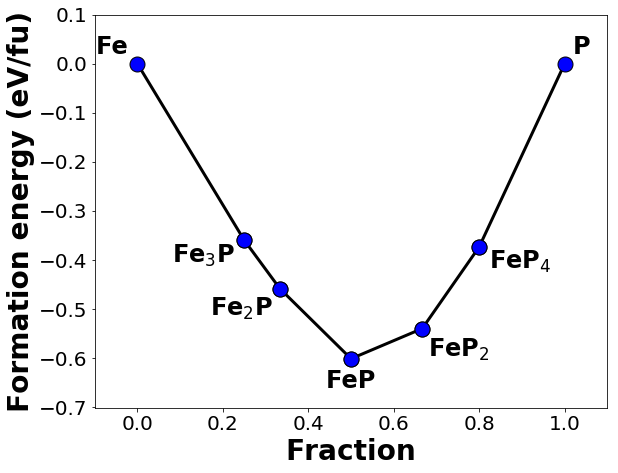

In [19]:
plotter = PDPlotter(pd, show_unstable=0)
plotter.show()

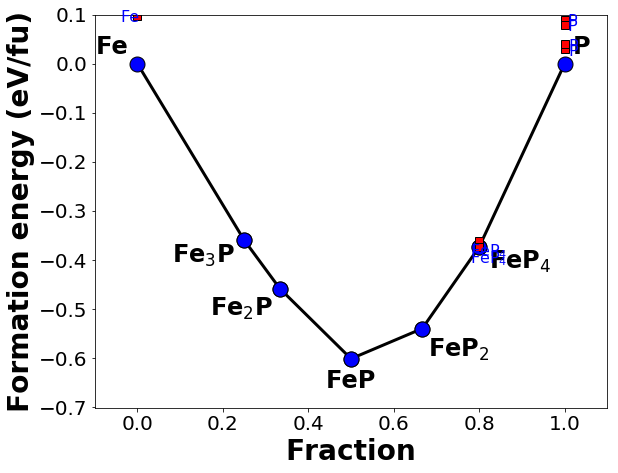

In [20]:
plotter = PDPlotter(pd, show_unstable=0.100)
plotter.show()

Let's analyze the phase diagram to list stable and unstable entries.

In [26]:
pda = PDAnalyzer(pd)

A table of stable entries:

In [36]:
for e in pd.stable_entries:
    print("{}\t{}".format(e.composition.reduced_formula, e.entry_id))

Fe3P	mp-18708
FeP2	mp-20027
Fe	mp-13
P	mp-568348
FeP	mp-1005
Fe2P	mp-778
FeP4	mp-570553


Now, let's print a table of unstable entries, inlcuding their energy above hull and predicted decomposition. Since this is more involved display-wise, we'll use a handy and popular library for dealing with data frames and displaying them nicely inline.

In [37]:
from pandas import DataFrame

In [38]:
import collections

data = collections.defaultdict(list)
for e in pd.unstable_entries:
    decomp, ehull = pda.get_decomp_and_e_above_hull(e)
    data["Materials ID"].append(e.entry_id)
    data["Composition"].append(e.composition.reduced_formula)
    data["Ehull"].append(ehull)    
    data["Decomposition"].append(
        " + ".join(["{:.2f} {} [{}]".format(
                    v, k.composition.reduced_formula, k.entry_id)
                    for k, v in decomp.items()]))

from pandas import DataFrame
df = DataFrame(data, columns=[
        "Materials ID", "Composition", "Ehull", "Decomposition"])

df

NameError: name 'pda' is not defined

In [ ]:
mpr.query('mp-27164', ['e_above_hull'])

Let's examine another chemical system: C-Ca-O.

In [39]:
entries = mpr.get_entries_in_chemsys(['Ca', 'C', 'O'])
pd = PhaseDiagram(compat.process_entries(entries))

/Users/jdagdelen/anaconda/envs/mp/lib/python3.6/site-packages/numpy/linalg/linalg.py:1821: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


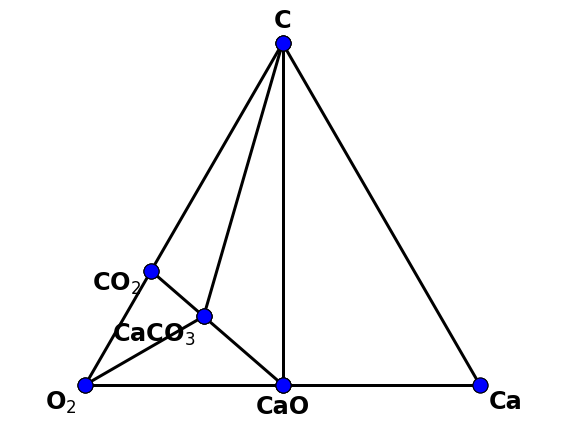

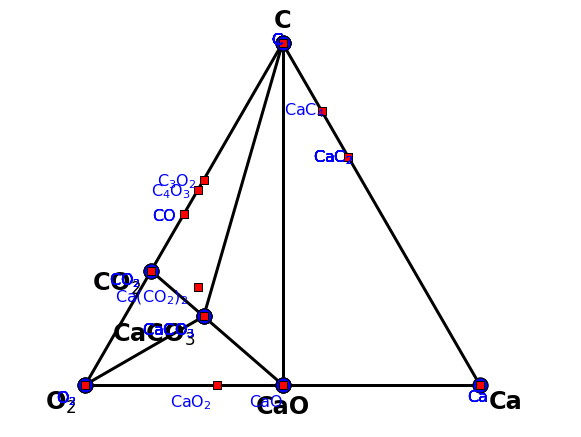

In [44]:
plotter1 = PDPlotter(pd, show_unstable=False)
plotter1.show()
plotter2 = PDPlotter(pd, show_unstable=True)
plotter2.show()

In [34]:
pda = PDAnalyzer(pd)

And let's print out all entries now, stable and unstable.

In [35]:
import collections

data = collections.defaultdict(list)
for e in pd.all_entries:
    decomp, ehull = pda.get_decomp_and_e_above_hull(e)
    data["Materials ID"].append(e.entry_id)
    data["Composition"].append(e.composition.reduced_formula)
    data["Ehull"].append(ehull)    
    data["Decomposition"].append(
        " + ".join(["{:.2f} {} [{}]".format(
                    v, k.composition.reduced_formula, k.entry_id)
                    for k, v in decomp.items()]))

from pandas import DataFrame
df = DataFrame(data, columns=[
        "Materials ID", "Composition", "Ehull", "Decomposition"])

df

,Materials ID,Composition,Ehull,Decomposition
0,mp-1023923,O2,1.004394,1.00 O2 [mp-12957]
1,mp-607540,O2,0.112355,1.00 O2 [mp-12957]
2,mp-610917,O2,0.023777,1.00 O2 [mp-12957]
3,mp-12957,O2,0.000000,1.00 O2 [mp-12957]
4,mp-611836,O2,0.013366,1.00 O2 [mp-12957]
5,mp-973916,O2,0.007882,1.00 O2 [mp-12957]
6,mp-560602,O2,0.414823,1.00 O2 [mp-12957]
7,mp-1009490,O2,0.005418,1.00 O2 [mp-12957]
8,mp-632329,C,0.110332,1.00 C [mp-568286]
9,mp-568028,C,0.528945,1.00 C [mp-568286]


## Calculating reaction energies
pymatgen.org example

In [40]:
from pymatgen.matproj.rest import MPRester
from pymatgen import Composition
from pymatgen.entries.computed_entries import ComputedEntry
from pymatgen.core.units import FloatWithUnit
from pymatgen.analysis.reaction_calculator import ComputedReaction

#This initializes the REST adaptor. Put your own API key in.
# mpr = MPRester()

#This gets all entries belonging to the Ca-C-O system.
all_entries = mpr.get_entries_in_chemsys(['Ca', 'C', 'O'])

#This method simply gets the lowest energy entry
#for all entries with the same composition.
def get_most_stable_entry(formula):
    relevant_entries = [
        entry for entry in all_entries
        if entry.composition.reduced_formula == Composition(formula).reduced_formula]
    relevant_entries = sorted(relevant_entries, key=lambda e: e.energy_per_atom)
    return relevant_entries[0]

CaO = get_most_stable_entry("CaO")
CO2 = get_most_stable_entry("CO2")
CaCO3 = get_most_stable_entry("CaCO3")

reaction = ComputedReaction([CaO, CO2], [CaCO3])
energy = FloatWithUnit(reaction.calculated_reaction_energy, "eV atom^-1")

print("Caculated")
print(reaction)
print("Reaction energy = {}".format(energy.to("kJ mol^-1")))
print

# The following portions demonstrate how to get the experimental values as well.
exp_CaO = mpr.get_exp_entry("CaO")
exp_CaCO3 = mpr.get_exp_entry("CaCO3")

#Unfortunately, the Materials Project database does not have
# gas phase experimental entries.
# This is the value from NIST. We manually create the entry.
#Exp entries should be in kJ/mol.
exp_CO2 = ComputedEntry("CO2", -393.51)

exp_reaction = ComputedReaction([exp_CaO, exp_CO2], [exp_CaCO3])

print("Experimental")
print(exp_reaction)
print("Reaction energy = {} kJ mol^-1".format(
    exp_reaction.calculated_reaction_energy))

Caculated
CaO + CO2 -> CaCO3
Reaction energy = -145.39165028828774 kJ mol^-1
Experimental
CaO + CO2 -> CaCO3
Reaction energy = -178.3000000000004 kJ mol^-1
